# Statistics and Trends
## Applied Data Science 1
### MSc Data Science (with placement year)
#### University of Hertfordshire
**Author:** Cristina Baron Suarez <br>


In [74]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import scipy.stats as ss
from scipy.optimize import curve_fit

The dataset provided is focused on health and physical activity measured through accelerometers, and it has been provided by a research group at the University of Malaga. I previously made use of these data for my Bachelor's Degree Final Project, and I am now contributing to the computational aspects of their ongoing work. The dataset consists of measurements of various numerical variables from over 2,000 walks carried out within the framework of the PredimedPlus study in Malaga, Spain.

In [75]:
filename = 'walkingSample.csv'
df = pd.read_csv(filename).iloc[:,4:] # Read and select all columns from the 5th-on
df.head()

,ENMO_mean_wb5,dur_wb5,dur_wb_10_90_3m_i2m_wb5,ENMO_sd_wb5,ENMO_mean_wb_10_90_3m_i2m_wb5,VPA_pc_wb5,wb01_pc_wb5,fragwb01
0,164.13,47.42,30.58,155.57,225.50,0.122944,0.903205,0.093392
1,107.34,41.08,32.67,61.50,116.31,0.001947,0.951315,0.076766
2,143.10,13.17,11.33,70.09,155.08,0.006074,0.949127,0.160000
3,144.03,18.17,14.67,99.40,165.60,0.009356,0.853054,0.193548
4,151.37,96.17,76.42,96.22,187.68,0.002600,0.800665,0.025974


## Statistical analysis

Below, we are going to show all major moments, usign the 'describe()' function, and adding to the resultant dataframe the skewness and the kurtosis for each column.

In [76]:
# We create an extended version of the describe function in order to add the skewness and the kurtosis
def describe_extended(data):
    """
    Adds skewness and kurtosis to the pandas describe() function.
    
    Parameter: 
    - 'data': The DataFrame on which to calculate descriptive statistics.
    Returns: A DataFrame with the descriptive statistics and two additional columns: skewness and kurtosis.
    """
    skewness = data.skew().round(2) # Calculates the skewness of each column. Returns only 2 decimals.
    kurtosis = data.kurtosis().round(2) # Calculates the kurtosis of each column. Returns only 2 decimals.
    
    # Transposes the DataFrames for 'skewness' and 'kurtosis', converting columns into rows
    # Renames the index of the first row to identify each metric
    skewness_df = pd.DataFrame(skewness).T.rename(index = {0: 'skewness'})
    kurtosis_df = pd.DataFrame(kurtosis).T.rename(index = {0: 'kurtosis'})
    
    # Concatenates the DataFrame to 'describe' (which only returns 2 decimals)
    return pd.concat([data.describe().round(2), skewness_df, kurtosis_df])

In [249]:
dg = describe_extended(df)
dg

,ENMO_mean_wb5,dur_wb5,dur_wb_10_90_3m_i2m_wb5,ENMO_sd_wb5,ENMO_mean_wb_10_90_3m_i2m_wb5,VPA_pc_wb5,wb01_pc_wb5,fragwb01
count,2483.00,2483.00,2483.00,2483.00,2483.00,2483.00,2483.00,2483.00
mean,187.26,52.13,41.92,97.18,202.41,0.06,0.91,0.08
std,95.44,46.99,36.41,46.83,95.72,0.15,0.09,0.05
min,59.71,10.00,3.00,27.51,58.07,0.00,0.57,0.01
25%,130.50,17.12,14.58,66.50,145.68,0.00,0.85,0.05
50%,165.58,37.00,28.92,87.14,180.40,0.01,0.94,0.08
75%,213.80,70.71,59.17,113.41,228.84,0.04,1.00,0.11
max,1045.91,324.33,258.42,405.32,1054.09,1.00,1.00,0.27
skewness,3.40,1.94,1.78,2.28,3.33,4.20,-0.92,0.99
kurtosis,18.93,4.82,3.97,8.59,18.36,19.64,0.07,0.86


We will look at the actual data before choosing what should be clustered. For that, we create a pair plot and a correlation matrix.

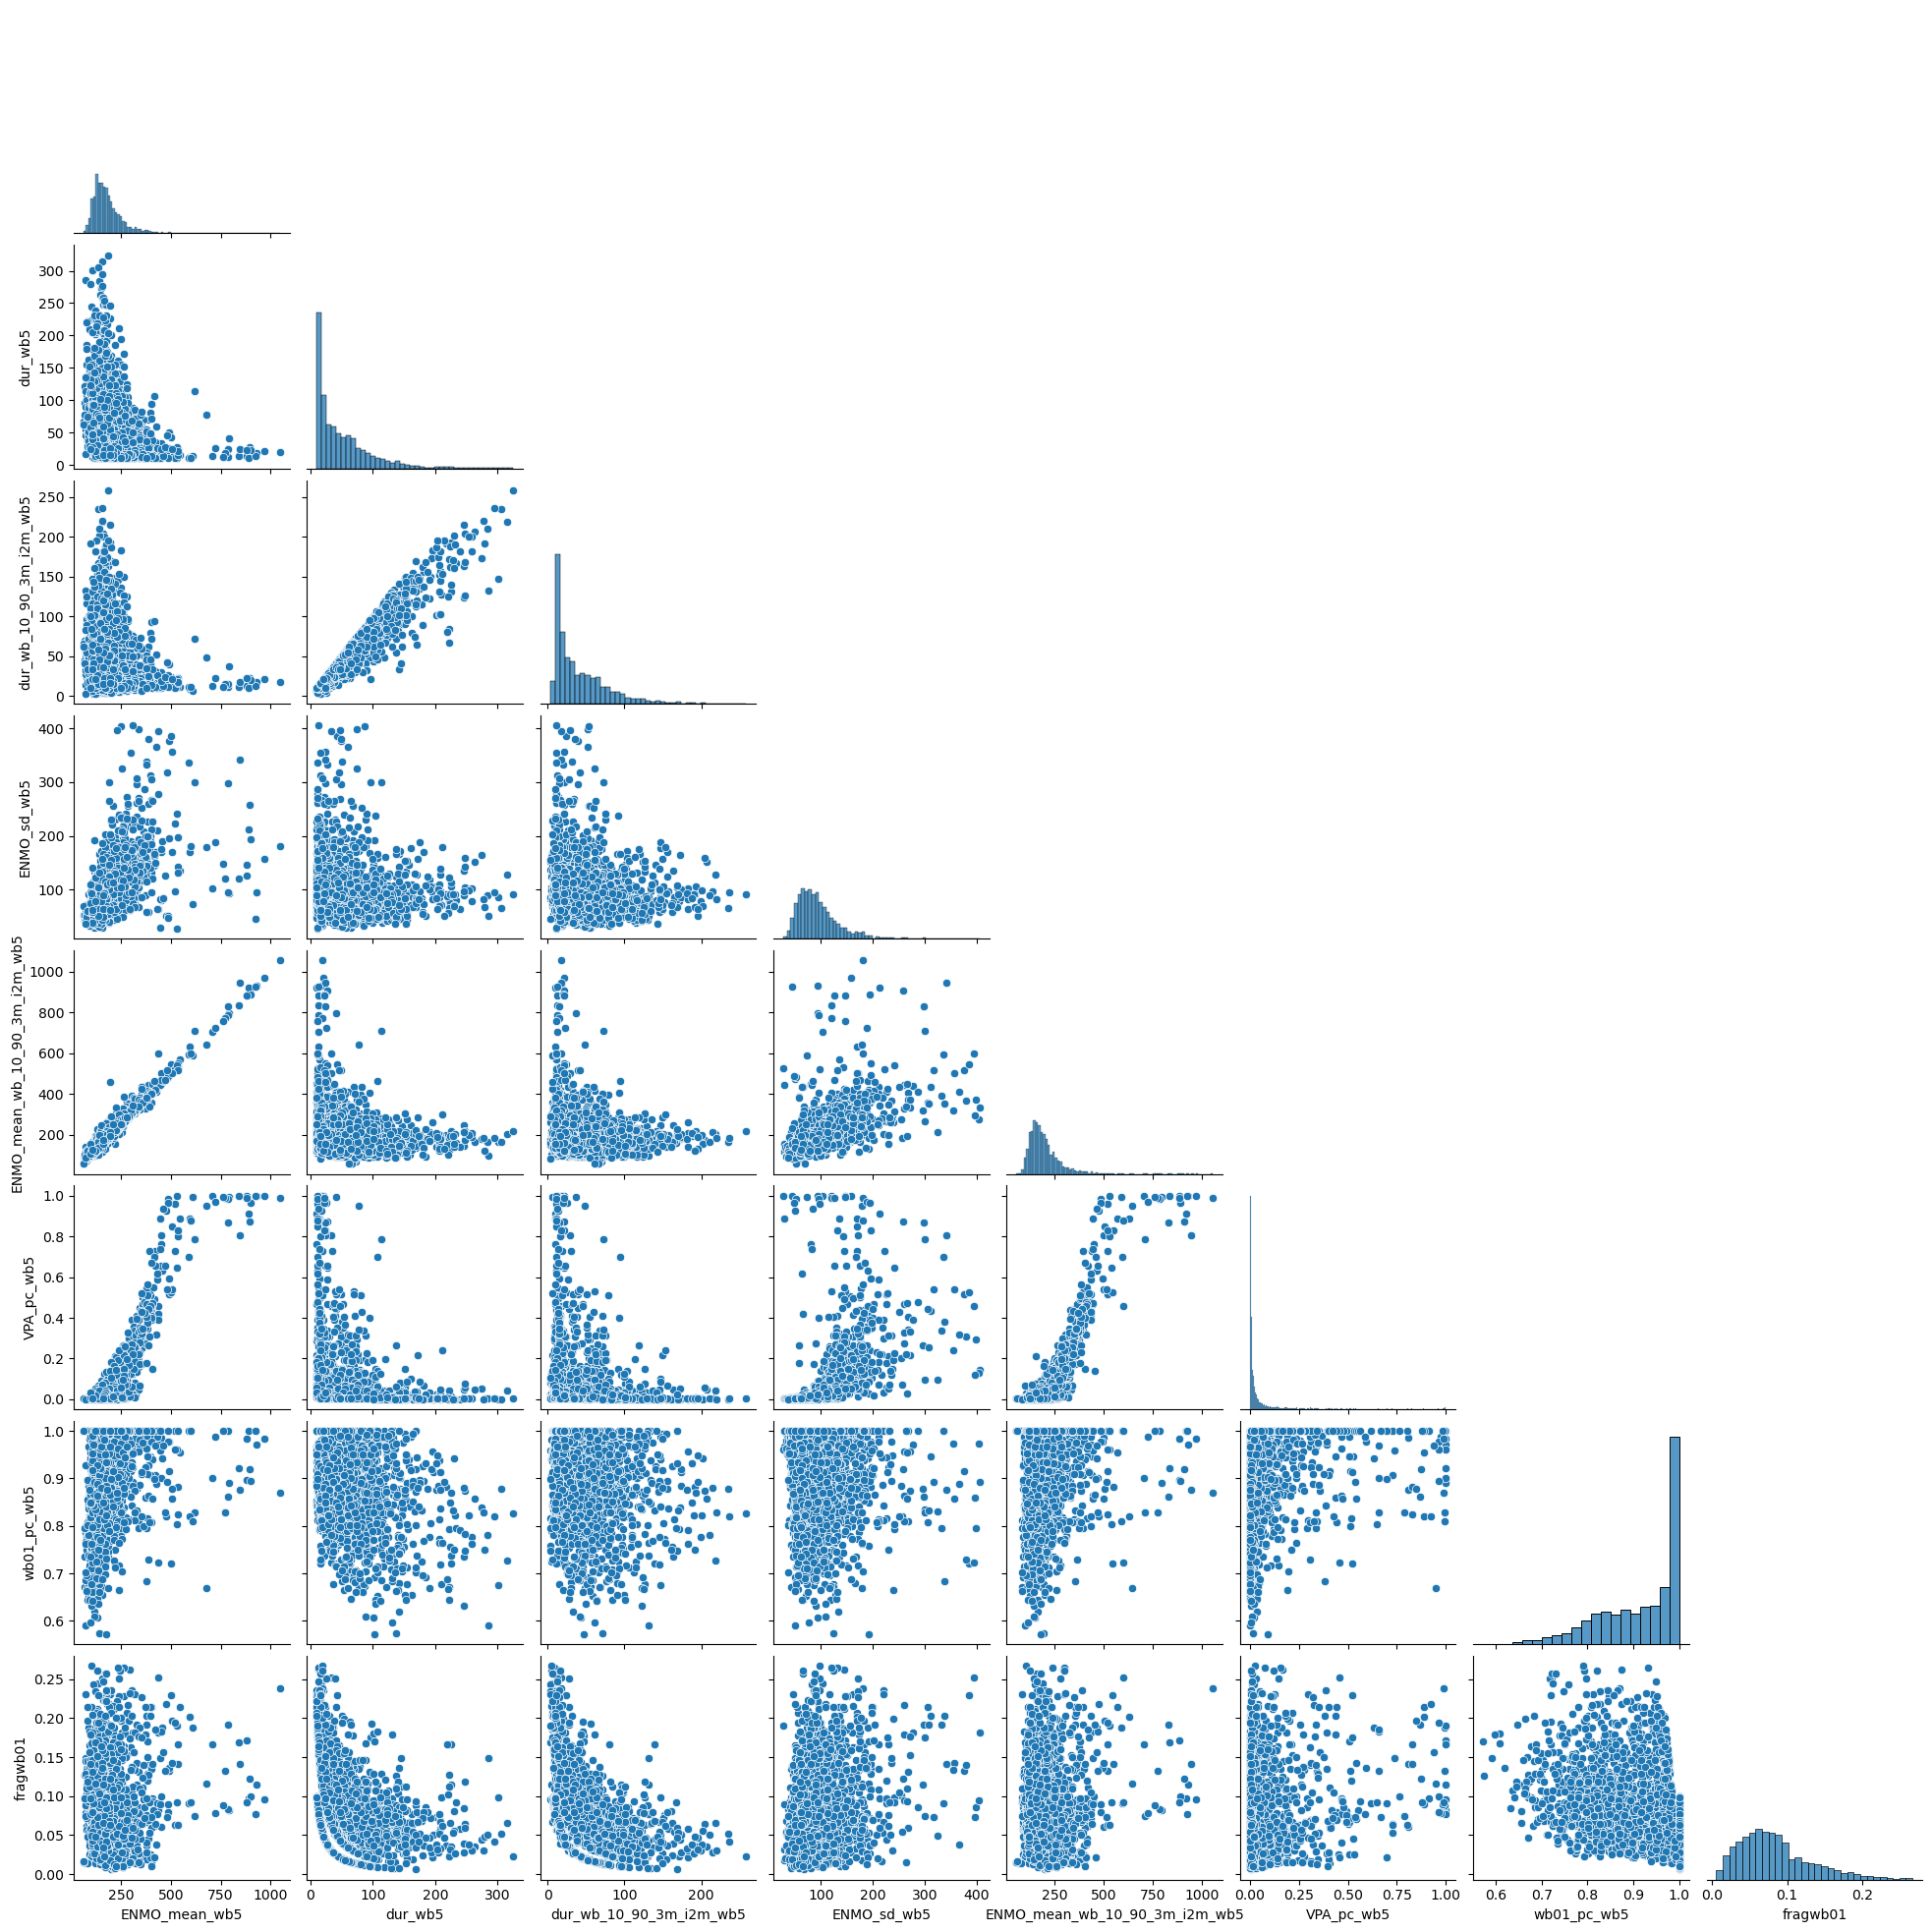

In [77]:
def pairplot(df):
    """
    Plots pairwise relationships in a dataset, only showing the lower triangle.

    Parameters:
    - 'df': The DataFrame containing the data to be plotted
    """
    sns.pairplot(df, corner = True)
    plt.show()
    return

pairplot(df)

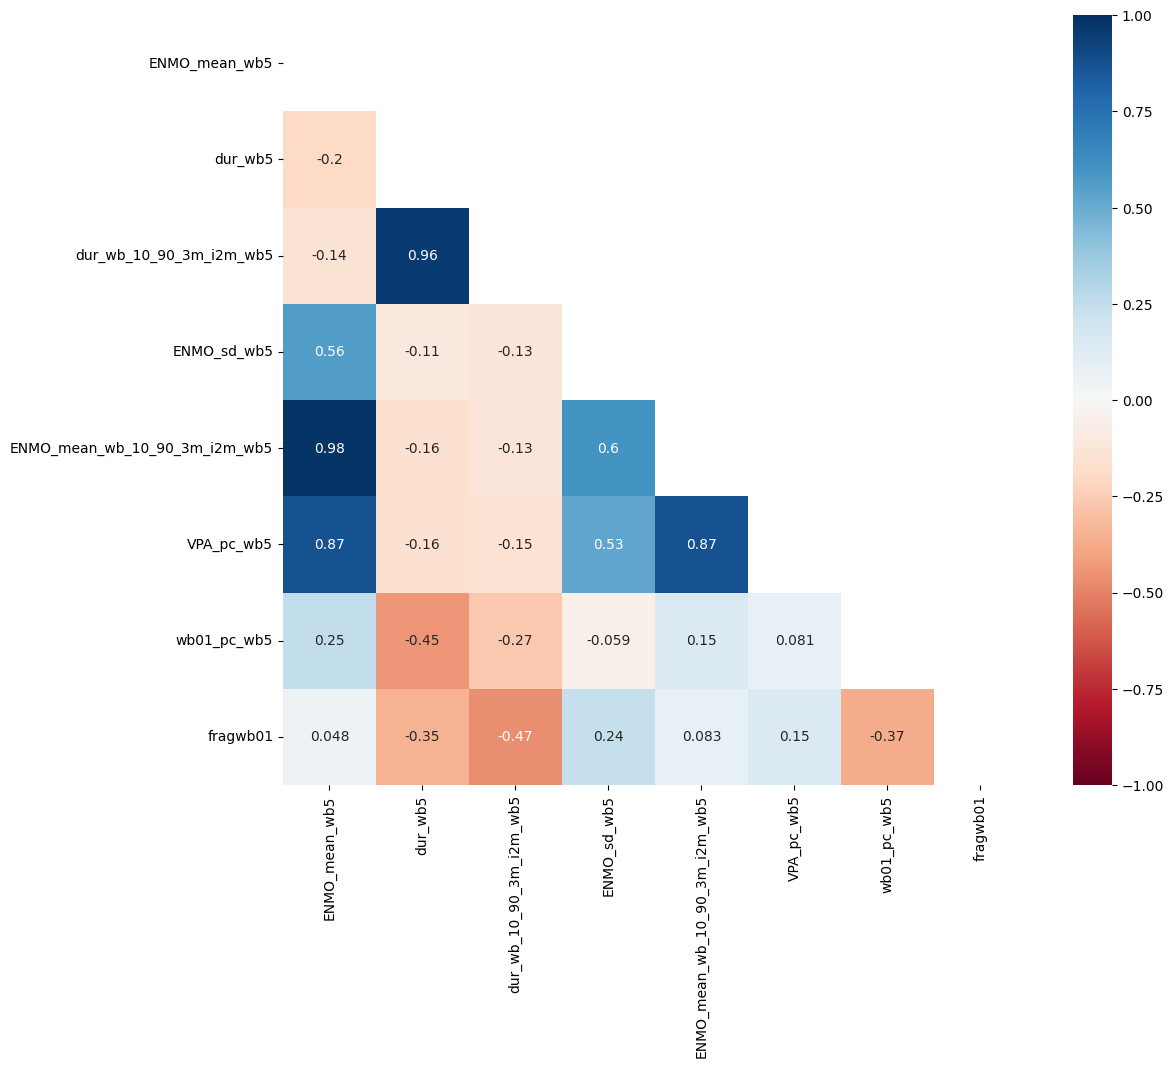

In [251]:
def heatmap(df):
    """
    Generates a heatmap for the correlation matrix of the 'df' dataframe.
    It applies a mask to the upper triangle of the correlation matrix to avoid redundant information.

    Parameters:
    - 'df': The DataFrame for which the correlation matrix will be computed
    """
    fig, ax = plt.subplots(figsize = (12, 10))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(df.corr()))

    # Creates the correlation matrix
    sns.heatmap(df.corr(), ax = ax, vmin = -1, vmax = 1, cmap = 'RdBu', annot = True, mask = mask)
    plt.show()
    return

heatmap(df)

We could study `ENMO_mean_wb5` (mean intensity) versus `VPA_pc_wb5`, which measures the percentage of walking bout that it is spent in "Vigorous Physical Activity (VPA)".  These variables are somewhat linearly correlated, but not highly. 

In [78]:
def plot_histogram(df, cols, xlabels):
    """
    Plots a histogram for each specified column in a DataFrame. Each subplot shares the X and Y axis.
    
    Parameters:
    - 'df': The DataFrame containing the data to plot
    - 'cols': A list of the variables to plot as histograms
    - 'xlabels': A list with the name of the labels of the axis
    """
    fig, axes = plt.subplots(nrows = 1, ncols = len(cols), figsize = (12, 6), sharex = False, sharey = True)

    # Iterate through the columns to plot
    for i in range(0, len(cols)):
        #Plot the histogram for each column
        axes[i].hist(df[cols[i]], bins = 20, edgecolor = 'black', color = 'skyblue')
        axes[i].set_xlabel(xlabels[i], fontsize = 14)
        axes[i].set_ylabel('Frequency', fontsize = 14)
        axes[i].tick_params(axis = 'x', labelsize = 14)
        axes[i].tick_params(axis = 'y', labelsize = 14)
        axes[i].grid()
    
    plt.show()
    return



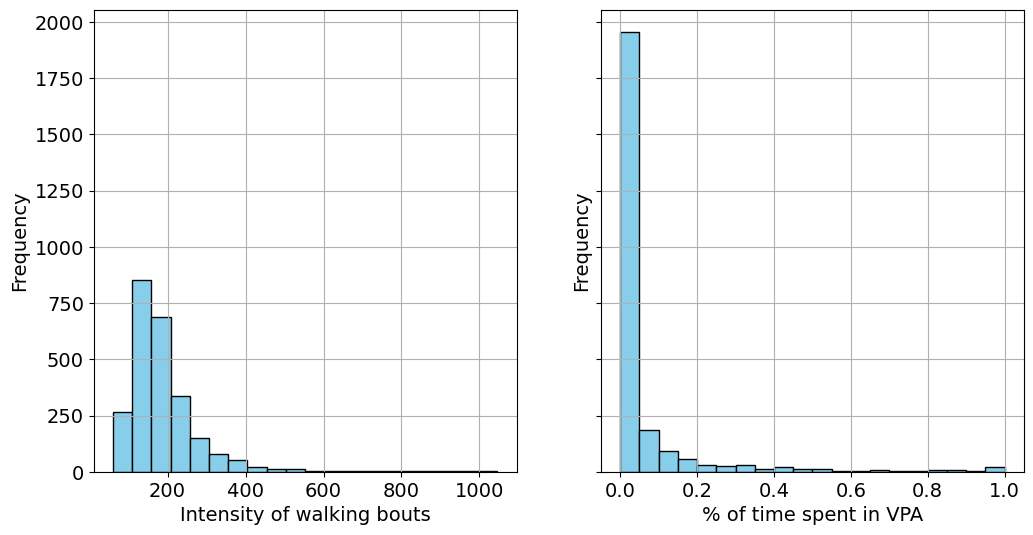

In [80]:
cols = ['ENMO_mean_wb5', 'VPA_pc_wb5']
xlabels = ['Intensity of walking bouts', '% of time spent in VPA']
plot_histogram(df, cols,xlabels)

As we can see in the previous histogram, the values are not normally distributed. For that reason, we are going to use the robust scaler to standarize the columns.

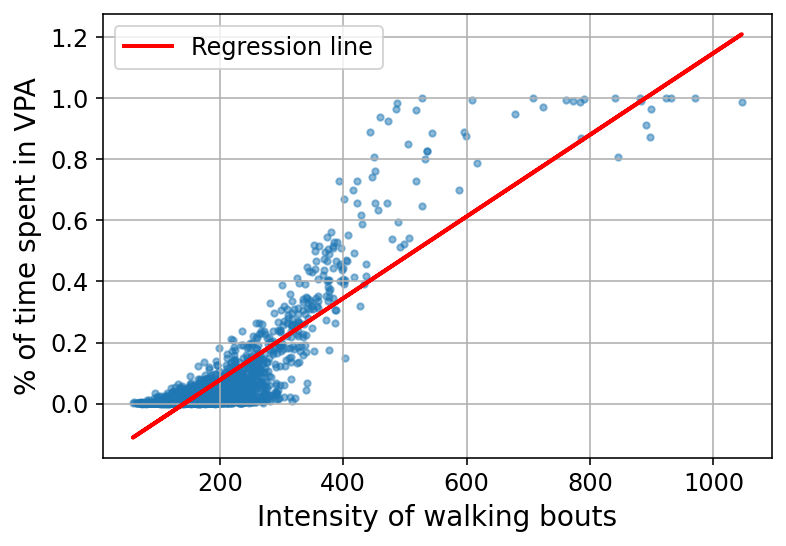

In [81]:
def plot_regresion(df, vars, xlabels):
    """
    Plots a scatter plot and a linear regression line for the variables we want to study
    
    Parameters: 
    - 'df' : The DataFrame containing the data
    - 'vars': A list with the variables to be studied
    - 'xlabels': A list with the labels of these variables
    """
    # Creates the figure and the axes
    fig, ax = plt.subplots(dpi = 144, figsize = (6, 4))

    # Generates a scatter plot comparing the first variable against the second one
    ax.scatter(df[vars[0]], df[vars[1]], marker = 'o', s = 10, alpha = 0.5)

    # Sets a linear regression line (degree 1) to the data
    m, b = np.polyfit(df[vars[0]], df[vars[1]], 1)
    
    # Draws a regression line with a confidence interval of 95%
    ax.plot(df[vars[0]], m * df[vars[0]] + b, color = "red", label = "Regression line", linewidth = 2)
    
    ax.grid(True)
    ax.set_xlabel(xlabels[0], fontsize = 14)
    ax.set_ylabel(xlabels[1], fontsize = 14)
    ax.tick_params(labelsize = 12)
    ax.legend(fontsize = 12)
    
    plt.show()
    return

plot_regresion(df, cols, xlabels)

The linear model does not seem like the best regression option as the range of the Y-variable is limited. Because of that, we will now check if the logistic curve is a better approximation.

In [82]:
def logistic(x, n0, g, x0):
    """
    Calculates the logistic function with scale factor n0 and growth rate g
    """
    f = n0 / (1 + np.exp(-g*(x - x0)))
    return f

In [83]:
# Create regresion as the last function but using a logistic model:
def plot_logisticregresion(df, vars, xlabels):
    """
    Plots a scatter plot and a logistic regression line for the variables we want to study
    
    Parameters: 
    - 'df' : The DataFrame containing the data
    - 'vars': A list with the variables to be studied
    - 'xlabels': A list with the labels of these variables
    """
    # Creates the figure and the axes
    fig, ax = plt.subplots(dpi = 144, figsize = (6, 4))

    # Generates a scatter plot comparing the first variable against the second variable
    ax.scatter(df[vars[0]], df[vars[1]], marker = 'o', s = 10, alpha = 0.5)

    # Sets a logistic regression line to the data
    X = df[vars[0]].values
    Y = df[vars[1]].values

    # Maximum of Y
    n0_initial = 1
    # Growth rate
    g_initial = 1 # The relation seem to be positive
    # Some value in the middle range for X
    x0_initial = np.median(X)

    initial_guess = [n0_initial, g_initial, x0_initial]

    # Curve fit adjustement
    params, cov = curve_fit(logistic, X, Y, p0 = initial_guess)
    n0_fit, g_fit, x0_fit = params

    # Range of X values for the fitted curve
    X_fit = np.linspace(min(X), max(X), 100)
    Y_fit = logistic(X_fit, n0_fit, g_fit, x0_fit)

    # Draws a logistic regression line in the graph with a confidence interval of 95%
    ax.plot(X_fit,  Y_fit, color = "red", label = "Logistic regression line", linewidth = 1)
    
    # Calculate the confidence interval
    # Take 1000 normal random samples for each parameter
    sample_params = ss.multivariate_normal.rvs(mean = params, cov = cov, size = 1000)
 
    # Determine uncertainty at each prediction using 2 standard deviations (CI 95%)
    Y_uncertainties = [2 * np.std(logistic(X, *sample_params.T)) for X in X_fit]
    ax.fill_between(X_fit, Y_fit - Y_uncertainties, Y_fit + Y_uncertainties, color = 'gray', alpha = 0.5)

    ax.grid(True)
    ax.set_xlabel(xlabels[0], fontsize = 14)
    ax.set_ylabel(xlabels[1], fontsize = 14)
    ax.tick_params(labelsize = 12)
    ax.legend(fontsize = 12)
    
    plt.show()
    return

/tmp/ipykernel_2134895/1812387413.py:5: RuntimeWarning: overflow encountered in exp
  f = n0 / (1 + np.exp(-g*(x - x0)))


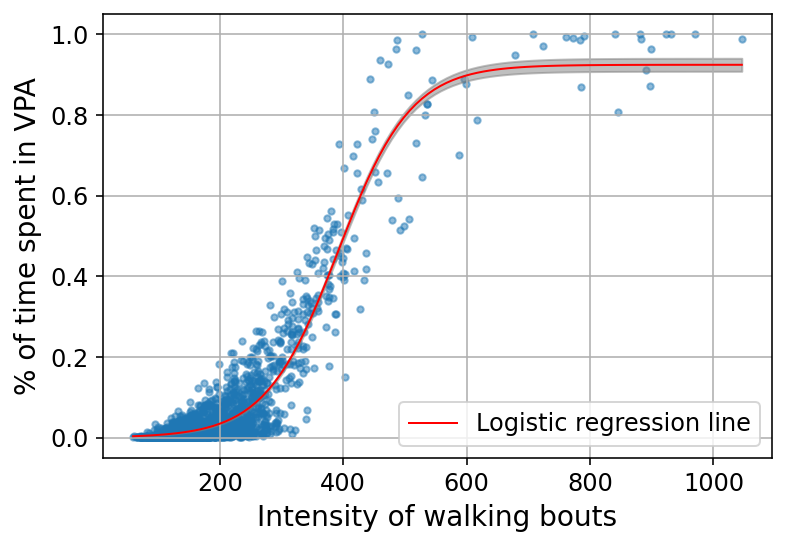

In [84]:
plot_logisticregresion(df, cols, xlabels)

Definitely, this model fit is better than the previous one. Next, we are going to use the robust scaler to standarize the columns.  

In [85]:
# Standarize all columns
df_clust = df[cols].copy()
scaler = RobustScaler()

# Fit the scaler to the data and transform it to normalized values
norm = scaler.fit_transform(df_clust)

## Clustering and fitting

Now, we are going to use the silhouette score method in order to determine the best number of clusters. For that, we are going to compare how close the data points are within a cluster and the separation between clusters.

In [86]:
def one_silhoutte(n, df):
    """
    Calculates the silhoutte score for n clusters
    """
    # Random seed for reproducibility
    np.random.seed(1) 
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters = n, n_init = 20)
    # Fit the data
    kmeans.fit(df)
    labels = kmeans.labels_
    # calculate the silhoutte score
    score = silhouette_score(df, labels)
    return score

In [88]:
# To track the best number of clusters and the highest silhouette score
best_n, best_score = None, -np.inf

# Iterate from 2 to 10 clusters
for n in range(2, 11):
    # Calculate the silhouette score for 'n'
    score = one_silhoutte(n, df)
    
    # If the current score is higher, update the best number of clusters and score
    if score > best_score:
        best_n = n
        best_score = score
    
    # Print the silhouette score for 'n'
    print(f"{n:2g} clusters silhouette score = {score:0.2f}")

# Print the best number of clusters
print(f"Best number of clusters = {best_n:2g}")

 2 clusters silhouette score = 0.61
 3 clusters silhouette score = 0.45
 4 clusters silhouette score = 0.35
 5 clusters silhouette score = 0.38
 6 clusters silhouette score = 0.32
 7 clusters silhouette score = 0.30
 8 clusters silhouette score = 0.29
 9 clusters silhouette score = 0.30
10 clusters silhouette score = 0.28
Best number of clusters =  2


According to the silhouette score method, the best number of clusters is 2. Let's now explore it with the elbow method.

In [89]:
def elbowPlot(df, ini, end, best_n):
    """
    Plots the elbow method between ini and end
    """
    # List to store the inertia values for each number of clusters
    inertia = [] # Squared distances to cluster centers
    
    # Loop through the range of cluster numbers (ini to end)
    for k in range(ini, end):
        # Perform k-means clustering with k clusters
        np.random.seed(1) 
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(df)
        # Append the inertia to the list
        inertia.append(kmeans.inertia_)
    
    # Plot the inertia values against the number of clusters
    plt.plot(range(ini, end), inertia, 'x-', label = 'Inertia')
    # Highlight the best number of clusters
    plt.scatter(best_n, inertia[best_n - ini], marker = 'o', color = 'red', facecolors = 'none', s = 50, label = 'Best number of clusters')
    plt.xlabel('Number of clusters', fontsize = 14)
    plt.ylabel('Inertia', fontsize = 14)
    plt.xticks(fontsize =14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 12)
    plt.show()
    return

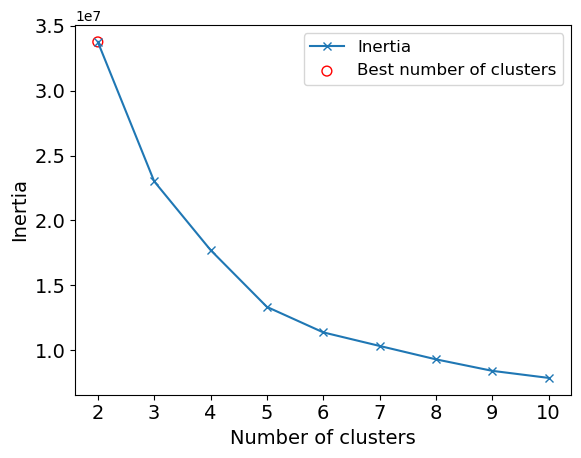

In [90]:
elbowPlot(df, 2, 11, best_n)

The silhoutte score method propose two as the best number of clusters. However, looking at the elbow plot, I would rather choose three, or even five, clusters. Let's look at the proposed clusters so the decision become less abstract:

In [91]:
def plot_fitted(cols, labels, xlabels, df, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot, with centres shown.

    Parameters:
    - 'cols': list with the X and Y axis variables
    - 'labels': array of cluster labels for each data point
    - 'xlabels': list with the labels for the X and Y axis
    - 'df': DataFrame containing the data to be plotted
    - 'xkmeans': array of the x coordinates of the cluster centers
    - 'ykmeans': array of the y coordinates of the cluster centers
    - 'centre_labels': array of labels for the cluster centers
    """
    # Generate a color map for each cluster label
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    cmap = ListedColormap(colours)

    # Create a scatter plot
    fig, ax = plt.subplots(dpi = 144)
    scatter = ax.scatter(df[cols[0]], df[cols[1]], c = labels, cmap = cmap, marker = 'o', alpha = 0.20, s = 2, label = 'Data')

    # Plot the cluster centers
    ax.scatter(xkmeans, ykmeans, c = centre_labels, cmap = cmap, marker = 'x', s = 300, label = 'Estimated Centres')

    # Add a color bar and legend
    cbar = fig.colorbar(scatter, ax = ax)
    cbar.set_ticks(np.unique(labels))
    cbar.set_ticklabels(['Cluster {}'.format(int(i)) for i in np.unique(labels)])

    # Set labels and legend
    ax.legend()
    ax.set_xlabel(xlabels[0])
    ax.set_ylabel(xlabels[1])

    plt.show()
    return

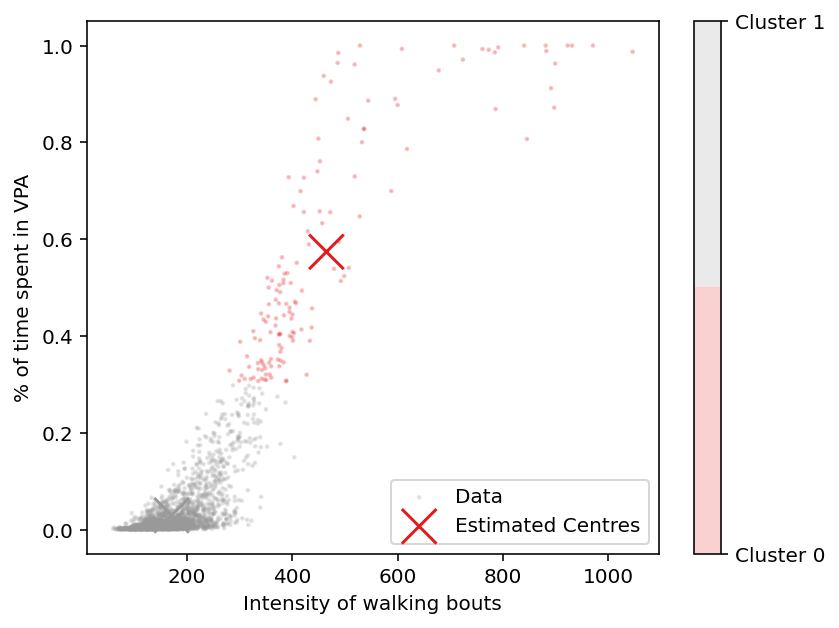

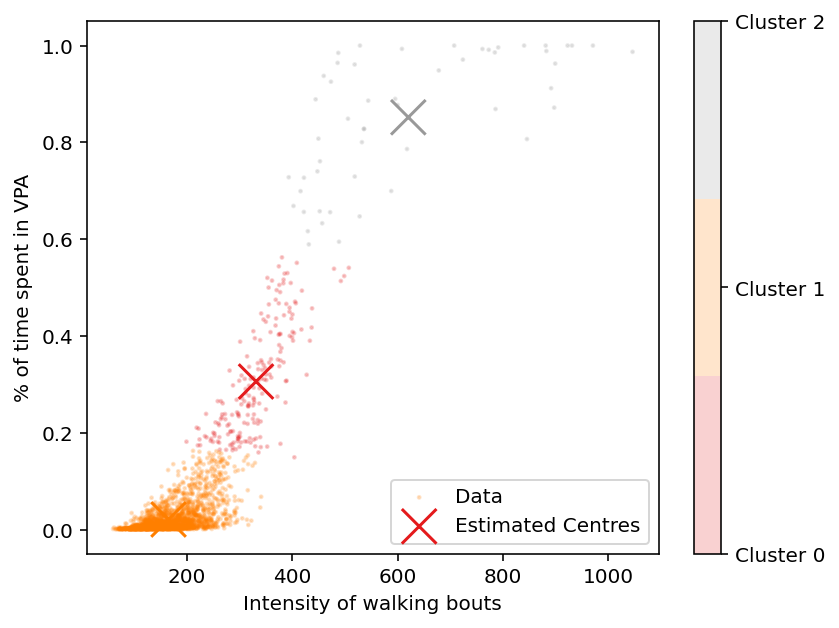

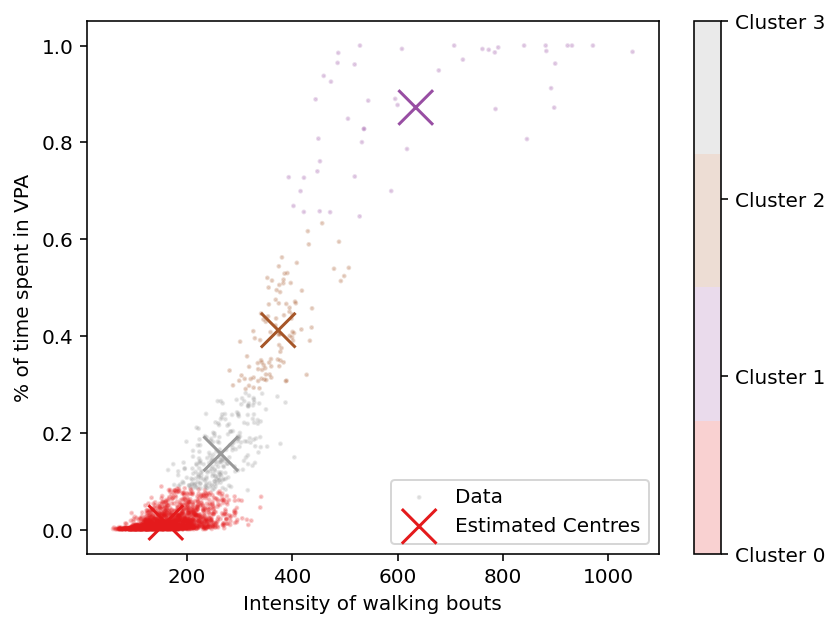

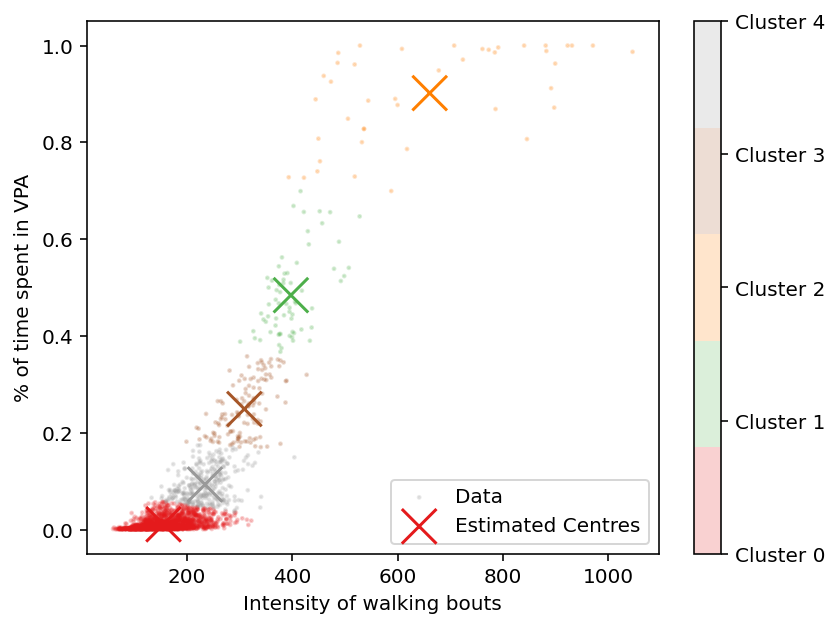

In [92]:
# Bring the normalized data back to its original scale
inv_norm = scaler.inverse_transform(norm)

# Iterate from 2 to 5 clusters
for k in range(2, 6):
    np.random.seed(1) 
    kmeans = KMeans(n_clusters = k, n_init = 20)
    kmeans.fit(norm) # fit done on x,y pairs
    # Extract the cluster labels for each data point
    labels = kmeans.labels_
    # Transform estimated cluster centers back to the original scale
    cen = scaler.inverse_transform(kmeans.cluster_centers_)
    xkmeans = cen[:, 0] # X-coordinates of cluster centers
    ykmeans = cen[:, 1] # Y-coordinates of cluster centers
    # Predict cluster labels for the estimated cluster centers
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    plot_fitted(cols, labels, xlabels, df, xkmeans, ykmeans, cenlabels)

After observing these last plots, I personally find choosing three clusters as the best election. It divides the walking bouts according to intensity in three types:
- Cluster 1: Bouts with low mean intensity that contains low probability of intervals of VPA (people running).
- Cluster 0: Bouts with medium mean intensity that contains moderate probability of doing intervals with VPA.
- Cluster 2: Bouts with high mean intensity that contains high probability of people doing continuous VPA intervals.

In [93]:
# Specify the number of clusters
numClusters = 3

# Initialize the KMeans clustering model with the specified number of clusters
np.random.seed(1) 
kmeans = KMeans(n_clusters = numClusters)

# Fit the KMeans model to the dataFrame
kmeans.fit(df)

# Predict the cluster labels for each data point
y_kmeans = kmeans.predict(df)

# Store the cluster labels
df[f'Cluster{numClusters}'] = y_kmeans

# Display the number of data points in each cluster
df[f'Cluster{numClusters}'].value_counts()

Cluster3
1    1790
0     654
2      39
Name: count, dtype: int64

As expected, the cluster more frequent is the one that has the less intense activity, folowed by those more intense (Cluster 0 and Cluster 2). Let's now show box plots for the variables in each of those clusters:

In [113]:
def boxplot(data, columns, xlabels, numClusters):
    """
    Generates a boxplot per column, grouped by clusters.

    Parameters:
    - 'data': Dataset containing the data to be plotted
    - 'columns': List of column names
    - 'xlabels': List of labels of the column names
    - 'numClusters': The number of clusters
    """
    # Iterate through the list of columns to create a subplot for each of them
    for i in range(len(columns)):
        # Create a subplot for the current column
        plt.subplot(1, len(columns), i + 1)
        # Plot a boxplot for the current column grouped by the cluster column
        sns.boxplot(x = f'Cluster{numClusters}', y = columns[i], data = data)
        
        plt.xlabel('Clusters', fontsize = 14)
        plt.ylabel(xlabels[i], fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

    # Adjust the horizontal space between subplots
    plt.subplots_adjust(wspace = 0.6)
    
    plt.show()
    return

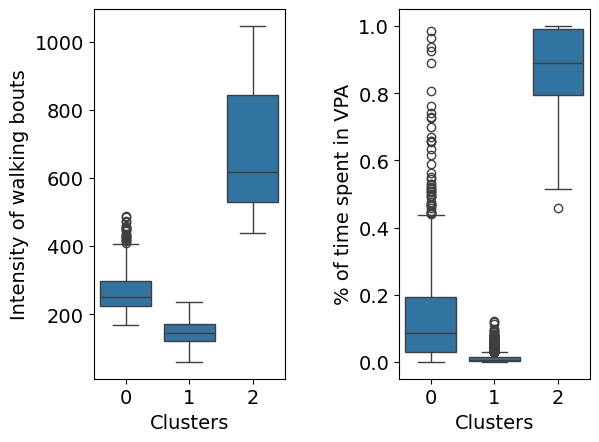

In [112]:
boxplot(df, cols, xlabels, numClusters)

These boxplots can be interpreted as follows:
- Cluster 2 are composed mainly by those walking bouts that are done in high mean intensity. Those are made by people that usually spend a high percent of that time in VPA.
- Cluster 1 is composed by walks that rarely spend any percent of time in VPA. They are usually ealks in the lower intensity of ENMO (mean acceleration).
- Cluster 0 is composed by walks that have a moderate mean intensity with some of them expending some time in VPA.